# Inferring Cosmo from PM Simulation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)
# !nvidia-smi

feynmangpu04.cluster.local
gpu [cuda(id=0)]


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
# numpyro.set_platform("gpu")
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk, cic_compensation
# import haiku as hk

from jaxpm.painting import cic_paint, cic_read
from jaxpm.utils import gaussian_smoothing, power_spectrum

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

## Probabilistic Model

In [4]:
from montecosmo.models import cosmo_prior, linear_pk_interp, linear_field

def forward_model(box_size, mesh_size, scale_factor_lpt, galaxy_density, trace_deterministic=False):
  """
  A forward model, where the relevant variables can be traced.
  """
  # Sample cosmology
  cosmology = cosmo_prior(trace_deterministic=True)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  if trace_deterministic:
    init_mesh = numpyro.deterministic('init_mesh', init_mesh)

  # Create regular grid of particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement with LPT
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor.
  particles_pos = particles_pos + dx

  # Cloud In Cell painting
  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  if trace_deterministic:
    lpt_mesh = numpyro.deterministic('lpt_mesh', lpt_mesh)

  # Observe
  ## Direct observation
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Delta(lpt_mesh))
  ## Normal noise 
  # lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Normal(lpt_mesh, 0.1))
  ## Poisson noise
  gxy_intens_mesh = (lpt_mesh + 1) * (galaxy_density * box_size.prod() / mesh_size.prod())
  lpt_mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Poisson(gxy_intens_mesh))
  return lpt_mesh_obs

In [5]:
# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 32 # 64
box_length = 320 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factor
model_kwargs['scale_factor_lpt'] = 0.1

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

## Debugging
model_kwargs['trace_deterministic'] = True

cell_lengths=[10.0, 10.0, 10.0] Mpc/h


2023-11-24 15:31:25.678890: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


k_nyquist=0.31416 h/Mpc, delta_k=0.01963 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

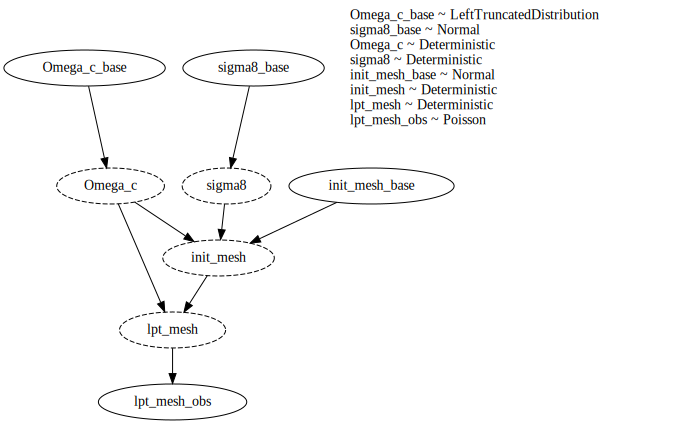

In [6]:
# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate

In [8]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones

# Get trace
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
fiducial_cosmology = jc.Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [28]:
from montecosmo.models import cic_compensate
# Get meshes from model trace
init_mesh, lpt_mesh = fiducial_model_trace['init_mesh']['value'], fiducial_model_trace['lpt_mesh']['value']

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
lpt_comp_mesh = cic_compensate(lpt_mesh) # compensate for CIC painting convolution
pk_lpt = power_spectrum(lpt_comp_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


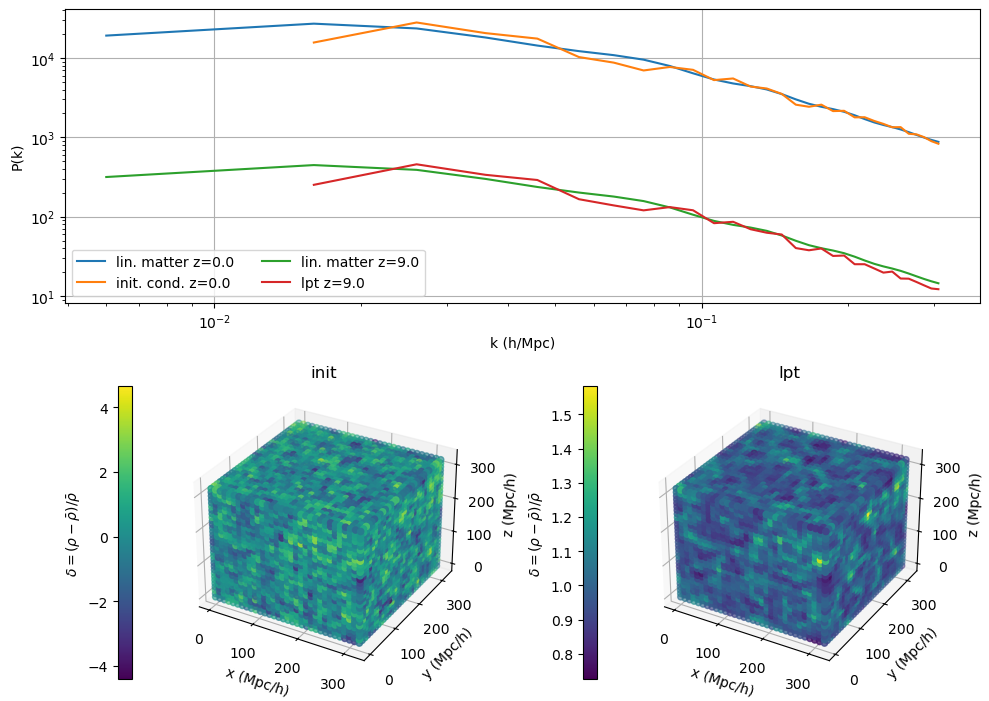

In [29]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"lin. matter z={1/1-1}")
plt.loglog(pk_init[0], pk_init[1], label=f"init. cond. z={1/1-1}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_lpt[0], pk_lpt[1], label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1}")
plt.grid(), plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")

# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
init_color = init_mesh.flatten()
lpt_color = lpt_mesh.flatten()
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(223, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("init")

ax3D = plt.subplot(224, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta = (\rho - \bar \rho) / {\bar \rho}$")
plt.title("lpt")

plt.tight_layout(), plt.show();

## Inference

In [112]:
# Condition model
obs_var_names = ['lpt_mesh_obs', 'init_mesh_base'] # NOTE: Only condition on random sites
obs_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in obs_var_names}
observed_model = condition(forward_model, obs_values)  

# Initialize sampler
init_var_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in init_var_names}

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    # init_strategy=partial(numpyro.infer.init_to_value, values=init_values),
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    max_tree_depth=3, # 3
    # inverse_mass_matrix=inverse_mass_matrix, 
    # adapt_mass_matrix=False,
    step_size=0.01, 
    # adapt_step_size=False
    )

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=500,
       num_samples=1000, # for each run
    #    chain_method="vectorized", 
    #    num_chains=8,
       progress_bar=True
       )

In [128]:
# Variables to save
save_var_names = cosmo_var_names + ['Omega_c_base', 'sigma8_base']
# Saves directory
save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/npys/"
save_name = "to_del_samples2"
# Number of runs
n_runs = 2

In [116]:
# Warmup sampling
if mcmc.num_warmup>=1:
    print(f"run {0}/{n_runs} (warmup)")
    key_warmup = random.PRNGKey(0)

    # Warmup
    mcmc.warmup(key_warmup, collect_warmup=True, **model_kwargs)
    warmup_samples = mcmc.get_samples()
    warmup_samples = {key: warmup_samples[key] for key in save_var_names}
    inverse_mass_matrix = mcmc.post_warmup_state.adapt_state.inverse_mass_matrix

    # Saving warmup
    save_path = os.path.join(save_directory, save_name+f"_{0}")
    np.save(save_path, warmup_samples)
    del warmup_samples

    # Handling rng key
    key_run = mcmc.post_warmup_state.rng_key
else:
    key_run = random.PRNGKey(0)

# Run sampling
for i_run in range(1, n_runs+1):
    print(f"run {i_run}/{n_runs}")
        
    # Run
    mcmc.run(key_run, **model_kwargs)
    run_samples = mcmc.get_samples()
    print(run_samples.keys())
    run_samples = {key: run_samples[key] for key in save_var_names}
    
    # Saving run
    save_path = os.path.join(save_directory, save_name+f"_{i_run}")
    np.save(save_path, run_samples)
    # del run_samples

    # Init next run at last state
    mcmc.post_warmup_state = mcmc.last_state
    key_run = mcmc.post_warmup_state.rng_key

run 0/2 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
  0%|          | 0/500 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getat

run 1/2


sample: 100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s, 3 steps of size 6.13e-01. acc. prob=0.93]
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'lpt_mesh', 'sigma8', 'sigma8_base'])
run 2/2


sample: 100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s, 7 steps of size 6.13e-01. acc. prob=0.93]


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'lpt_mesh', 'sigma8', 'sigma8_base'])


## Analysis

In [129]:
def load_and_append_runs(var_names, directory, file_name, start_run, end_run):
    """
    Load and append runs saved in different files with same name.
    """
    samples = {}
    for i_run in range(start_run, end_run+1):
        # Load
        load_path = os.path.join(directory, file_name+f"_{i_run}.npy")
        post_samples_part = np.load(load_path, allow_pickle=True).item()

        # Init or append samples
        if not samples:
            samples = {key: post_samples_part[key] for key in var_names}
        else:
            samples = {key: jnp.concatenate((samples[key], post_samples_part[key])) for key in var_names}
    print(f"total num samples={samples[var_names[0]].shape[0]}")
    return samples

cosmo_post_samples = load_and_append_runs(cosmo_var_names, save_directory, save_name, start_run=0, end_run=2)
cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T

total num samples=2500


In [104]:
inverse_mass_matrix

{('Omega_c_base',
  'init_mesh_base',
  'sigma8_base'): Array([0.12038596, 0.6692828 , 1.0407752 , ..., 0.7864685 , 0.7546326 ,
        1.025255  ], dtype=float32)}

In [105]:
jax.tree_util.tree_unflatten(inverse_mass_matrix.keys(), inverse_mass_matrix.values())

AttributeError: 'dict_keys' object has no attribute 'unflatten'

In [78]:
list(inverse_mass_matrix.keys())[0], 

(('Omega_c_base', 'init_mesh_base', 'sigma8_base'),)

In [121]:
inverse_mass_matrix

{('Omega_c_base',
  'sigma8_base'): Array([0.07845823, 0.35478285], dtype=float32)}

In [134]:
0.08**2

0.0064

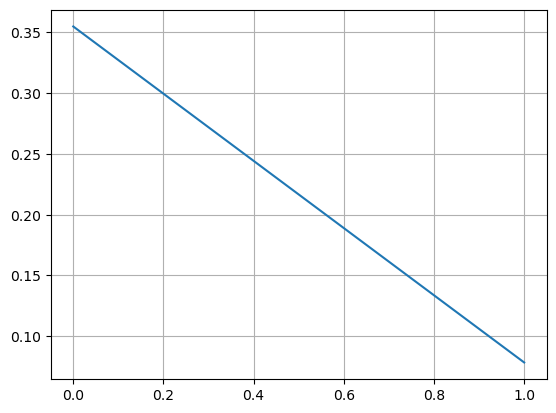

In [120]:
inverse_mass_matrix_arr = np.array(list(inverse_mass_matrix.values()))[0]
plt.plot(np.sort(inverse_mass_matrix_arr)[::-1])
plt.grid();

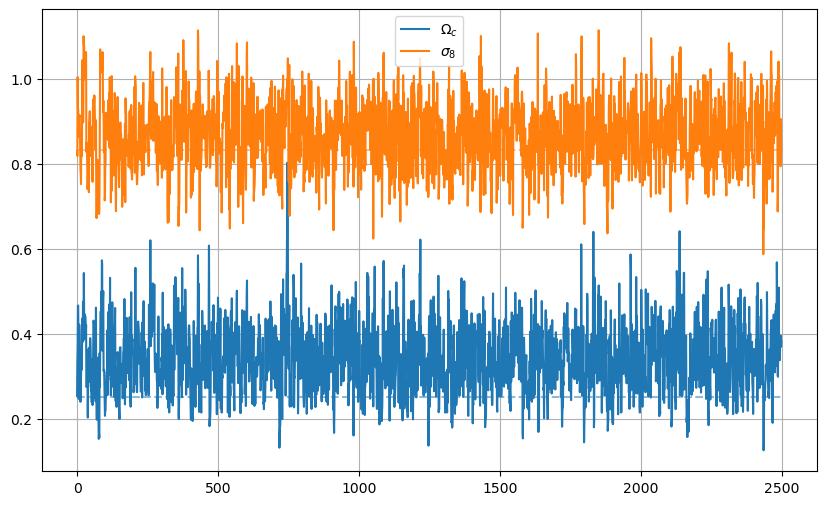

In [130]:
# Plot chain
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(cosmo_post_samples_arr, label=["$"+label+"$" for label in cosmo_var_labels])
plt.hlines(fiducial_cosmo_params.values(), 
           xmin=0, xmax=len(cosmo_post_samples_arr), 
           ls="--", alpha=0.5,
           color=["C"+str(i) for i in range(len(cosmo_post_samples_arr))],)
plt.legend(), plt.grid(), plt.show();

In [106]:
# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_deterministic=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.34      0.08      0.33      0.21      0.46    946.89      1.00
    sigma8      0.87      0.08      0.87      0.73      1.00    965.98      1.00

Removed no burn in
Removed no burn in


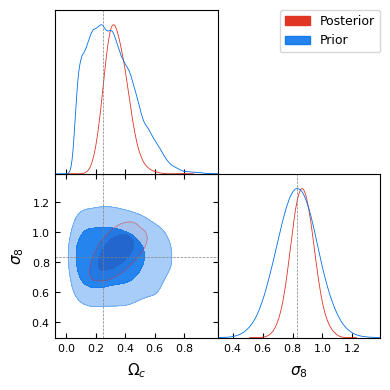

In [131]:
%matplotlib inline
# Diagnostics
numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
gd.triangle_plot(roots=[post_samples_gd, prior_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Posterior", "Prior"])